# predict sin

loss: 5.111112056304763e-07    d: [-0.47157024]    y: [-0.47258129]
loss: 1.415364045272599e-06    d: [-0.39789889]    y: [-0.39958137]
loss: 2.5599029914889695e-06    d: [-0.78740743]    y: [-0.78967013]
loss: 7.216263290756831e-09    d: [0.25526991]    y: [0.25514977]
loss: 1.692063852303836e-06    d: [0.6529121]    y: [0.6547517]
loss: 7.238070929592407e-07    d: [0.8773359]    y: [0.87613273]
loss: 6.94623672640184e-07    d: [0.92114593]    y: [0.91996727]
loss: 1.2284734878716838e-06    d: [-0.58880346]    y: [-0.59037093]
loss: 1.249746554038834e-08    d: [-0.6529121]    y: [-0.65307019]
loss: 1.747012227351786e-06    d: [-0.32751865]    y: [-0.32938788]
loss: 2.0214401036949676e-07    d: [0.39789889]    y: [0.39853473]
loss: 1.7248378220181487e-06    d: [-0.15674537]    y: [-0.1586027]
loss: 1.3462666565759927e-06    d: [0.97076771]    y: [0.97240861]
loss: 6.884294927340995e-07    d: [-0.50453668]    y: [-0.50571008]
loss: 8.964485145755927e-09    d: [-0.99460929]    y: [-0.994

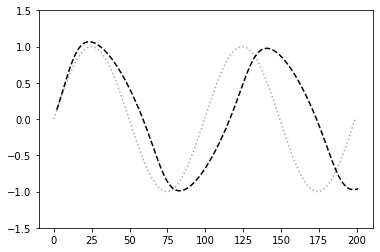

In [1]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 2

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 500

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
### [try]
-  iters_numを100にしよう
-  maxlenを5, iters_numを500, 3000(※時間がかかる)にしよう
---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

loss: 1.0018211688367868e-06    d: [-0.47157024]    y: [-0.47298574]
loss: 3.831628581739529e-05    d: [-0.39789889]    y: [-0.38914489]
loss: 1.1955502192448862e-05    d: [-0.78740743]    y: [-0.79229732]
loss: 5.688169957035194e-07    d: [0.25526991]    y: [0.25633651]
loss: 5.0427661317670666e-06    d: [0.6529121]    y: [0.65608787]
loss: 2.323535484703592e-05    d: [0.8773359]    y: [0.87051895]
loss: 1.2851597420607724e-05    d: [0.92114593]    y: [0.9160761]
loss: 2.9577805540631966e-06    d: [-0.58880346]    y: [-0.59123566]
loss: 5.303308701788967e-05    d: [-0.6529121]    y: [-0.64261325]
loss: 3.068291439526475e-05    d: [-0.32751865]    y: [-0.31968501]
loss: 5.63868323224144e-07    d: [0.39789889]    y: [0.39896084]
loss: 1.413552384893845e-05    d: [-0.15674537]    y: [-0.15142832]
loss: 1.3233060812017836e-05    d: [0.97076771]    y: [0.97591224]
loss: 1.358814640752647e-06    d: [-0.50453668]    y: [-0.50618521]
loss: 1.3524103237934098e-07    d: [-0.99460929]    y: [-0.

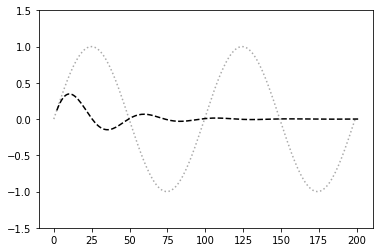

In [2]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 2

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 100

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

iter=100ではまったく学習が足りてない

loss: 1.9106530112992623e-06    d: [-0.29761864]    y: [-0.29566383]
loss: 4.009145134726445e-06    d: [-0.56307233]    y: [-0.56024067]
loss: 4.1170041815299796e-06    d: [-0.65766776]    y: [-0.65479826]
loss: 1.2186275784353541e-06    d: [0.13182648]    y: [0.13026531]
loss: 2.8569091862187926e-06    d: [0.49909101]    y: [0.49670065]
loss: 2.96835458163875e-05    d: [0.9518317]    y: [0.9441267]
loss: 3.0276143721344284e-05    d: [0.97784112]    y: [0.97005959]
loss: 3.462518923008676e-06    d: [-0.58880346]    y: [-0.58617192]
loss: 1.6259323267389834e-05    d: [-0.78351093]    y: [-0.77780842]
loss: 2.265698201956606e-06    d: [-0.49909101]    y: [-0.4969623]
loss: 1.582143105987843e-06    d: [0.21857331]    y: [0.21679447]
loss: 2.3430828768738427e-07    d: [-0.33938943]    y: [-0.33870488]
loss: 2.5337797976245463e-06    d: [-0.43793098]    y: [-0.43567986]
loss: 2.0617518493134026e-06    d: [-0.33346065]    y: [-0.33143001]
loss: 2.360468612841957e-05    d: [-0.99639027]    y:

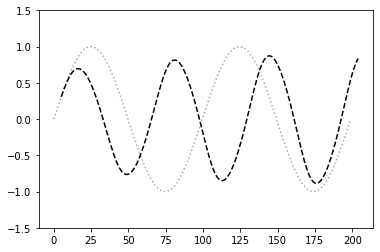

In [3]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 5

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 500

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

max_len=5, iter=500  
学習がある程度出来ているが、当てはまりが悪くなっているように見える 


loss: 1.0231756688240315e-07    d: [-0.29761864]    y: [-0.29716628]
loss: 1.2201090155920323e-08    d: [-0.56307233]    y: [-0.56322854]
loss: 4.038245319603949e-11    d: [-0.65766776]    y: [-0.65765877]
loss: 1.0126131714852026e-08    d: [0.13182648]    y: [0.13168417]
loss: 6.953992391227437e-08    d: [0.49909101]    y: [0.49871807]
loss: 5.5838333193818506e-08    d: [0.9518317]    y: [0.95149752]
loss: 1.006541644073702e-07    d: [0.97784112]    y: [0.97739245]
loss: 1.7033534573059554e-08    d: [-0.58880346]    y: [-0.58861889]
loss: 5.2622812685420113e-08    d: [-0.78351093]    y: [-0.78383534]
loss: 2.609182825988997e-10    d: [-0.49909101]    y: [-0.49906816]
loss: 5.7128497213479914e-08    d: [0.21857331]    y: [0.21823529]
loss: 9.126545094844397e-08    d: [-0.33938943]    y: [-0.3389622]
loss: 1.0304339135521172e-07    d: [-0.43793098]    y: [-0.43747701]
loss: 1.1445752972811905e-07    d: [-0.33346065]    y: [-0.3329822]
loss: 4.4870288964406624e-08    d: [-0.99639027]    

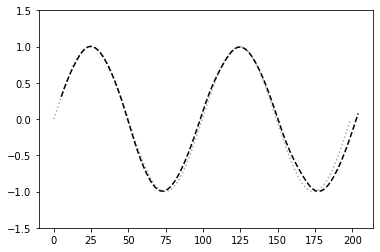

In [4]:
import sys, os
sys.path.append(os.pardir)  # 親ディレクトリのファイルをインポートするための設定
import numpy as np
from common import functions
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

np.random.seed(0)

# sin曲線
round_num = 10
div_num = 500
ts = np.linspace(0, round_num * np.pi, div_num)
f = np.sin(ts)

def d_tanh(x):
    return 1/(np.cosh(x)**2 + 1e-4)

# ひとつの時系列データの長さ
maxlen = 5

# sin波予測の入力データ
test_head = [[f[k]] for k in range(0, maxlen)]

data = []
target = []

for i in range(div_num - maxlen):
    data.append(f[i: i + maxlen])
    target.append(f[i + maxlen])
    
X = np.array(data).reshape(len(data), maxlen, 1)
D = np.array(target).reshape(len(data), 1)

# データ設定
N_train = int(len(data) * 0.8)
N_validation = len(data) - N_train

x_train, x_test, d_train, d_test = train_test_split(X, D, test_size=N_validation)

input_layer_size = 1
hidden_layer_size = 5
output_layer_size = 1

weight_init_std = 0.01
learning_rate = 0.1

iters_num = 3000

# ウェイト初期化 (バイアスは簡単のため省略)
W_in = weight_init_std * np.random.randn(input_layer_size, hidden_layer_size)
W_out = weight_init_std * np.random.randn(hidden_layer_size, output_layer_size)
W = weight_init_std * np.random.randn(hidden_layer_size, hidden_layer_size)

# 勾配
W_in_grad = np.zeros_like(W_in)
W_out_grad = np.zeros_like(W_out)
W_grad = np.zeros_like(W)

us = []
zs = []

u = np.zeros(hidden_layer_size)
z = np.zeros(hidden_layer_size)
y = np.zeros(output_layer_size)

delta_out = np.zeros(output_layer_size)
delta = np.zeros(hidden_layer_size)

losses = []

# トレーニング
for i in range(iters_num):
    for s in range(x_train.shape[0]):
        us.clear()
        zs.clear()
        z *= 0
        
        # sにおける正解データ
        d = d_train[s]

        xs = x_train[s]        
        
        # 時系列ループ
        for t in range(maxlen):
            
            # 入力値
            x = xs[t]
            u = np.dot(x, W_in) + np.dot(z, W)
            us.append(u)
            z = np.tanh(u)
            zs.append(z)

        y = np.dot(z, W_out)
        
        #誤差
        loss = functions.mean_squared_error(d, y)
        
        delta_out = functions.d_mean_squared_error(d, y)
        
        delta *= 0
        for t in range(maxlen)[::-1]:
            
            delta = (np.dot(delta, W.T) + np.dot(delta_out, W_out.T)) * d_tanh(us[t])
            
            # 勾配更新
            W_grad += np.dot(zs[t].reshape(-1,1), delta.reshape(1,-1))
            W_in_grad += np.dot(xs[t], delta.reshape(1,-1))
        W_out_grad = np.dot(z.reshape(-1,1), delta_out)
        
        # 勾配適用
        W -= learning_rate * W_grad
        W_in -= learning_rate * W_in_grad
        W_out -= learning_rate * W_out_grad.reshape(-1,1)
            
        W_in_grad *= 0
        W_out_grad *= 0
        W_grad *= 0

# テスト        
for s in range(x_test.shape[0]):
    z *= 0

    # sにおける正解データ
    d = d_test[s]

    xs = x_test[s]

    # 時系列ループ
    for t in range(maxlen):

        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)

    #誤差
    loss = functions.mean_squared_error(d, y)
    print('loss:', loss, '   d:', d, '   y:', y)
        
        
        
original = np.full(maxlen, None)
pred_num = 200

xs = test_head

# sin波予測
for s in range(0, pred_num):
    z *= 0
    for t in range(maxlen):
        
        # 入力値
        x = xs[t]
        u = np.dot(x, W_in) + np.dot(z, W)
        z = np.tanh(u)

    y = np.dot(z, W_out)
    original = np.append(original, y)
    xs = np.delete(xs, 0)
    xs = np.append(xs, y)

plt.figure()
plt.ylim([-1.5, 1.5])
plt.plot(np.sin(np.linspace(0, round_num* pred_num / div_num * np.pi, pred_num)), linestyle='dotted', color='#aaaaaa')
plt.plot(original, linestyle='dashed', color='black')
plt.show()

max_len=5, iter=3000  
学習に非常に時間がかかったが、ほぼ完ぺきに予測できるようになった